In [662]:
</div>

<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  } 
  
  $( document ).ready(function(){
    code_shown=false; 
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>

SyntaxError: invalid syntax (<ipython-input-662-d646ad0f3497>, line 1)

In [377]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

sns.set_style("darkgrid")

dam_levels = pd.read_csv('data/Dam-levels-clean-20120101-20171206.csv')
dam_levels['date'] = pd.to_datetime(dam_levels['date'])

# Add some date-related fields that will be useful later
dam_levels['year'] = dam_levels['date'].dt.year
dam_levels['month'] = dam_levels['date'].dt.month
dam_levels['monthname'] = dam_levels['date'].dt.strftime('%b')
dam_levels['week'] = dam_levels['date'].dt.week
dam_levels['dayofmonth'] = dam_levels['date'].dt.day
dam_levels['dayofyear'] = dam_levels['date'].dt.dayofyear
dam_levels['daymonth'] = dam_levels['dayofmonth'].apply(str) + '-' + dam_levels['monthname']
dam_levels['daymonthyear'] = dam_levels['dayofmonth'].apply(str) + '-' + dam_levels['monthname'] + '-' + dam_levels['year'].apply(str)

There are 14 dams in the dataset.

In [378]:
set(dam_levels['dam_name'])

{'Alexandra',
 'Berg River',
 'De Villiers',
 'Hely-Hutchinson',
 'Kleinplaats',
 'Land-En Zeezicht',
 'Lewis Gay',
 'Steenbras Lower',
 'Steenbras Upper',
 'Theewaterskloof',
 'Victoria',
 'Voëlvlei',
 'Wemmershoek',
 'Woodhead'}

Some summary statistics, grouped by dam, are displayed below. We can see that we have the same number of days' data for each dam, with the exception being Lewis Gay, which is missing a day, and Land-En Zeezicht, for which we have data for only 854 days'. Perhaps this is a newer dam. This could become important if we aggregate the data, since we'd could potentially be looking at a different sample of data at different time periods.

There is a lot of talk about the 'Big 6' dams, and looking at this table, we can see why. The minimum storage of the smallest of the 'Big 6' (Steenbras Lower) is larger than the maximum storage of the largest of the smaller dams (Kleinplaats).

In [379]:
storage_summary = dam_levels.groupby('dam_name')['storage_ml'].describe().sort_values('mean')
storage_summary

,count,mean,std,min,25%,50%,75%,max
dam_name,,,,,,,,
Alexandra,2167.0,70.155701,33.338326,0.0000,45.40,63.2,93.50000,134.200
Victoria,2167.0,89.571233,47.576707,0.0000,62.05,111.5,128.40000,134.200
Lewis Gay,2166.0,117.423730,49.951583,0.5000,88.25,127.2,165.80000,171.900
De Villiers,2167.0,186.063085,51.342229,57.6000,153.00,196.7,234.20000,246.200
Land-En Zeezicht,854.0,276.715223,126.081030,-0.0002,149.00,316.0,370.17925,473.149
Hely-Hutchinson,2167.0,691.201654,324.487382,0.0000,441.50,900.0,925.00000,961.000
Woodhead,2167.0,736.371620,157.729176,354.8000,613.40,731.0,896.80000,971.500
Kleinplaats,2166.0,805.428440,336.764605,228.4000,527.90,784.4,1108.00000,1333.100
Steenbras Lower,2167.0,21004.863406,7329.025332,7845.0000,15255.00,19054.0,27381.00000,34684.000


These numbers are all good and well but they aren't particularly compelling. The following boxplot highlights how dependent we are on the 'Big 6'.

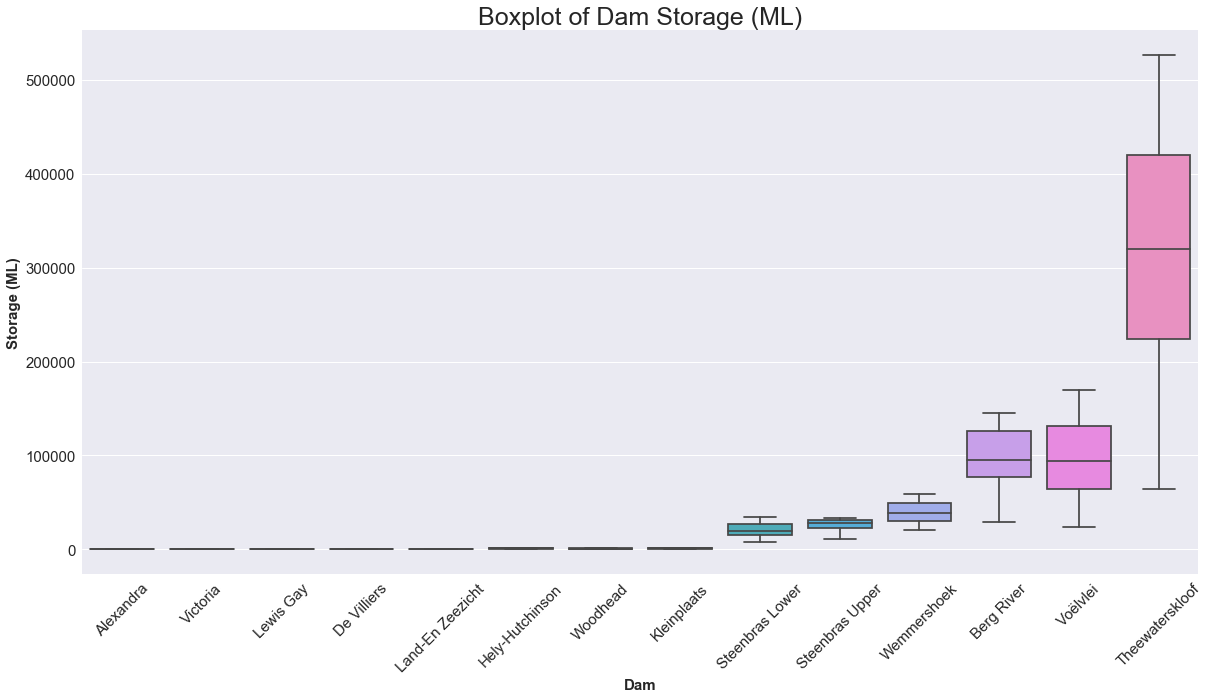

In [380]:
fig, ax = plt.subplots(figsize=[20,10]) # [w, h]
sns.boxplot(dam_levels['dam_name'], dam_levels['storage_ml'], order = storage_summary.index)
plt.xticks(rotation=45, fontsize = 15)
plt.xlabel('Dam', fontsize = 15, fontweight = 'bold')
plt.yticks(fontsize = 15)
plt.ylabel('Storage (ML)', fontsize = 15, fontweight = 'bold')
plt.title('Boxplot of Dam Storage (ML)', fontsize = 25);

Because the 'Big 6' are really the only dams that are going to have a material impact on the overall water supply of the region, and to make things simpler, I'm going to ignore the rest of the dams for the rest of my analysis.

In [381]:
dam_levels_all = dam_levels
big_6 = list(storage_summary.index)[-6:]
dam_levels = dam_levels[dam_levels['dam_name'].isin(big_6)]
dam_levels['dam_name'].unique()

array(['Berg River', 'Theewaterskloof', 'Voëlvlei', 'Steenbras Upper',
       'Steenbras Lower', 'Wemmershoek'], dtype=object)

Now lets get a sense of how the total water storage has changed for the available timeframe. 

The last 10% of the maximum capacity is 'unavailable', since the water is so sludgy at that point that it become incredibly difficult to extract. 

I needed to work out the maximum capacity for each dam, which we can mulitply by 10% to get the level at which the dams are empty for all intents and purposes. Adding this together gives us the total unavailable storage, which is just under 90,000 ML.

In [481]:
storage_ml_pivot = dam_levels.pivot_table(index = 'date', columns = 'dam_name', values = 'storage_ml')
agg_storage_ml = storage_ml_pivot.apply(np.sum, axis = 1)

# Work out available storage
## Work out maximum capacity
latest_dam_levels = dam_levels[dam_levels['date'] == '2017-12-06']
latest_dam_levels.index = latest_dam_levels['dam_name']
capacity = pd.DataFrame(index = latest_dam_levels['dam_name'])
capacity['max_storage_ml'] = latest_dam_levels['storage_ml']/(latest_dam_levels['current_%']/100)
## Work out 10% of capacity
capacity['unavailable_storage_ml'] = capacity['max_storage_ml'] * 0.1
## Aggregate
capacity = capacity.append(pd.Series(capacity.apply(func = sum, axis = 0), name = 'total'))
capacity

,max_storage_ml,unavailable_storage_ml
dam_name,,
Berg River,130010.000002,13001.000000
Theewaterskloof,480187.999929,48018.799993
Voëlvlei,164094.999989,16409.499999
Steenbras Upper,31767.000001,3176.700000
Steenbras Lower,33517.000003,3351.700000
Wemmershoek,58643.999996,5864.400000
total,898220.999920,89822.099992


In [486]:
# In the plots that follow, we'll want to be smart about how we label the x-axis. Too many labels will make it 
# unreadable but having too few will make it more difficult to see what date period we're looking at. 
# Generally we'll want to plot the 1st date of every month at a particular interval. We need to calculate an 
# associated index, which will tell the plotting library where to place the labels - that's what the `dayofyear` 
# and `cumsum_dayofyear` columns are doing in the dataframe below.

first_day_of_month = dam_levels.loc[(dam_levels['dayofmonth'] == 1), 
                                    ['date', 'year', 'month','dayofyear', 'daymonth', 'daymonthyear']].drop_duplicates()
first_day_of_month['lag_date'] = first_day_of_month['date'].shift(periods = 1)
first_day_of_month['cumsum_dayofyear'] = (first_day_of_month['date'] - first_day_of_month['lag_date']).dt.days.cumsum().fillna(0) + 1

The graph below shows how dangerously close we are to running out of water. The winter rains have helped to prop up the dam levels somewhat, but it's easy to see that the dam level drop between October and April last year is far greater than the quantity of available storage in October this year.

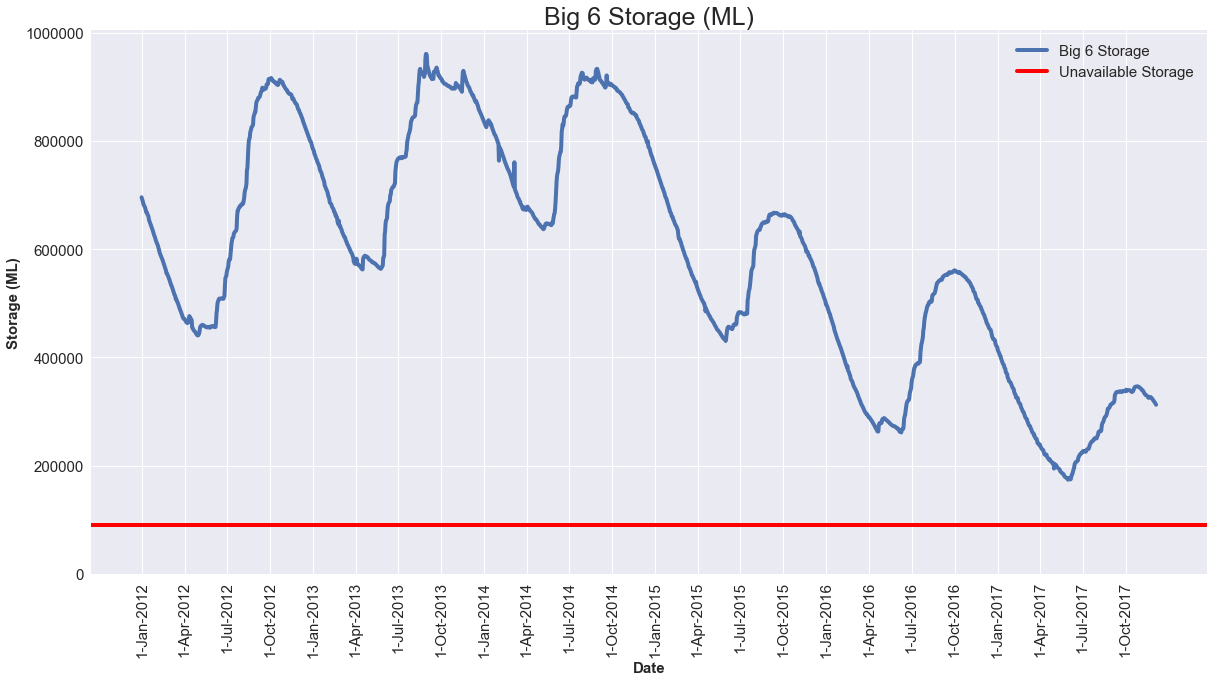

In [478]:
fig, ax = plt.subplots(figsize=[20,10]) # [w, h]
plt.plot(range(len(agg_storage_ml)),
         agg_storage_ml, 
         label = 'Big 6 Storage', 
         linewidth = 4)
ax.axhline(y = capacity.loc['total']['unavailable_storage_ml'], 
           label = 'Unavailable Storage', 
           c = 'red', 
           linewidth = 4)

first_day_of_quarter = first_day_of_month[first_day_of_month['month'].isin([1, 4, 7, 10])]

plt.xticks(first_day_of_quarter['cumsum_dayofyear'], first_day_of_quarter['daymonthyear'], rotation = 90, fontsize = 15);
plt.xlabel('Date', fontsize = 15, fontweight = 'bold')

plt.yticks(fontsize = 15)
plt.ylabel('Storage (ML)', fontsize = 15, fontweight = 'bold')
plt.ylim(ymin = 0)

plt.legend(fontsize = 15)
plt.title('Big 6 Storage (ML)', fontsize = 25);

I've shown a similar picture in the graph below, this time with each line showing a different year, and the units being percentage of the available dam level remaining. As you can see, the level were healthy in winter between 2012 and 2014. Even in summer of 2014, the level didn't go below 75%. It's only from 2015 that we see the dry winters starting to take their toll. We can see that the dams started filling up later in the year compared to the previous winters and stopped filling up much earlier. 

In [649]:
def plot_storage_perc(data, x_lab, y_lab, x_lim, y_lim, title):
    fig, ax = plt.subplots(figsize=[20,10]) # [w, h]

    for year in data.columns:
        if year == 2017:
            plt.plot(data[year], linewidth = 4, alpha = 1, c = 'black')
        else:
            plt.plot(data[year], linewidth = 4, alpha = 0.7)
    

    first_day_of_month_2013 = first_day_of_month.loc[first_day_of_month['year'] == 2013]

    ax.set_ylim(y_lim)
    plt.xticks(first_day_of_month_2013['dayofyear'], first_day_of_month_2013['daymonth'], fontsize = 15)
    plt.xlabel(x_lab, fontsize = 15, fontweight = 'bold')

    ax.set_xlim(x_lim)
    plt.yticks(fontsize = 15)
    plt.ylabel(y_lab, fontsize = 15, fontweight = 'bold')

    ax.legend(fontsize = 15)
    plt.title(title, fontsize = 25);
    

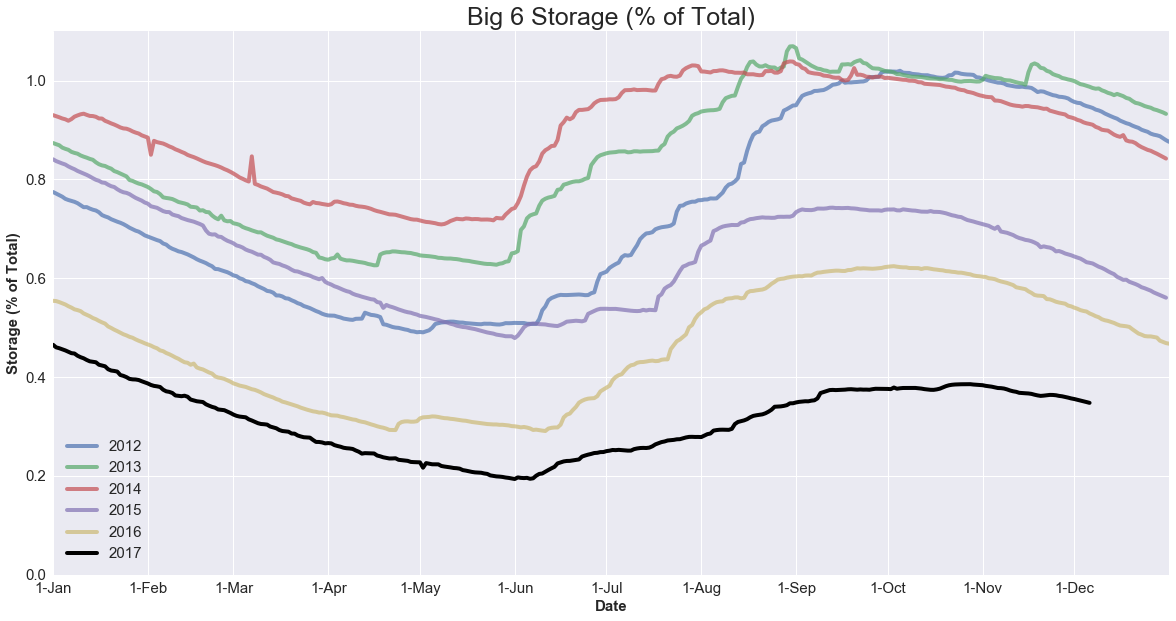

In [650]:
storage_ml_pivot = dam_levels.pivot_table(index = 'dayofyear', columns = 'year', values = 'storage_ml', aggfunc = sum)
storage_perc_pivot = storage_ml_pivot/(capacity.loc['total', 'max_storage_ml'])
plot_storage_perc(storage_perc_pivot, 'Date', 'Storage (% of Total)', (1, 366), (0, 1.1), 'Big 6 Storage (% of Total)')

Some good news we can see from the previous graph that the drawing down of dam levels since November has also happened at a lower pace than previous years - well done Cape Townians!

The figure below, showing percentage change in dam levels from the previous day, highlights this more starkely. This year's daily percentage change in dam levels (represented by the black line) is generally lower than than the other lines when the the chage is negative (dam levels are decreasing). We can see a little increase in dam levels towards late November, which is presumably due to some uncharacteristic (for the time period here) summer rains.

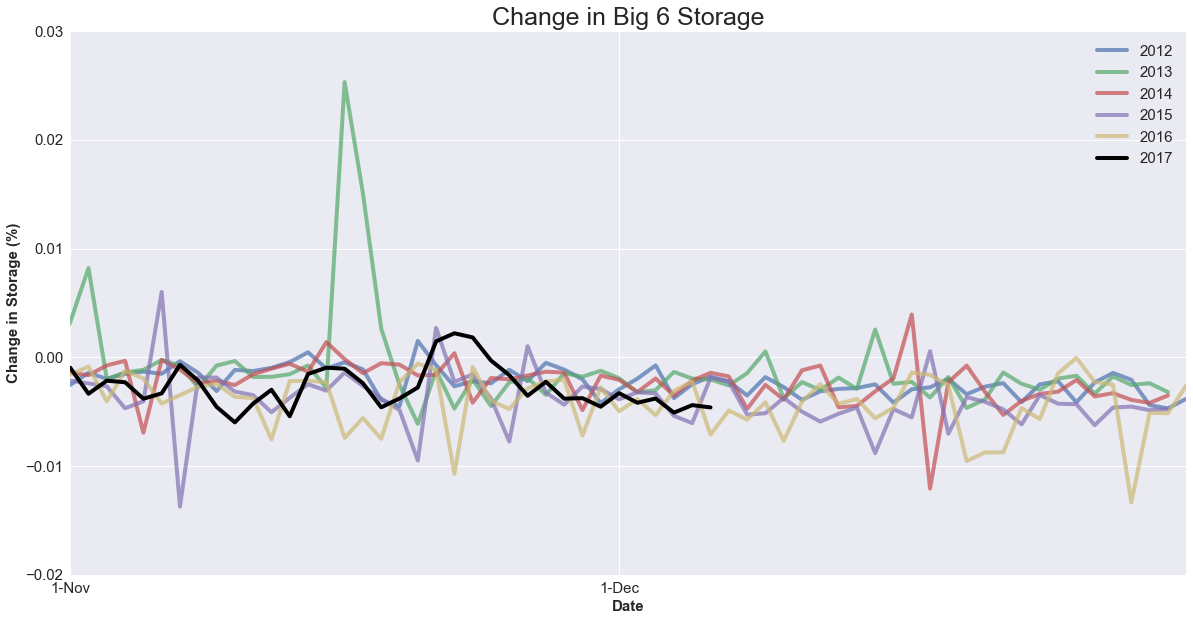

In [661]:
storage_percchange_pivot = storage_perc_pivot.pct_change(periods = 1, axis = 0)
plot_storage_perc(storage_percchange_pivot, 'Date', 'Change in Storage (%)', (305, 366), (-0.02, 0.03), 'Change in Big 6 Storage')